## Imports

In [1]:
import os
import cv2
import random

import pyarrow as pa
import lance

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [ ]:
# Download and unzip the data
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

!unzip Flickr8k_text.zip
!unzip Flickr8k_Dataset.zip

In [2]:
annotations_file = "Flickr8k.token.txt"
image_folder = "Flicker8k_Dataset/"

## Loading and Pre-processing

In flickr8k dataset, each image has multiple corresponding captions that are ordered. We are going to put all these captions in a list corresponding to each image with their position in the list being the number.

In [3]:
# Load the annotations in a list with each element of the list being a tuple consisting of image name, caption number and caption
with open(annotations_file, "r") as fl:
    annotations = fl.readlines()

annotations = list(map(lambda x: tuple([*x.split('\t')[0].split('#'), x.split('\t')[1]]), annotations))

In [4]:
# For all captions of the same image, put them in a list sorted by their ordering
captions = []
image_ids = set(ann[0] for ann in annotations)
for img_id in tqdm(image_ids):
    current_img_captions = []
    for ann_img_id, num, caption in annotations:
        if img_id == ann_img_id:
            current_img_captions.append((num, caption))
            
    # Sort by the annotation number
    current_img_captions.sort(key=lambda x: x[0])
    captions.append((img_id, tuple([x[1] for x in current_img_captions])))

  0%|          | 0/8092 [00:00<?, ?it/s]

Try plotting a random image from this list to see if the pre-processing was done correctly.

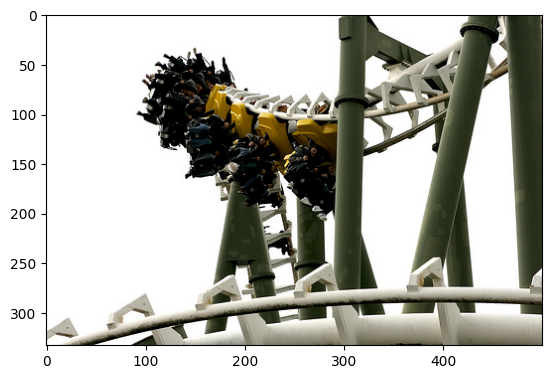

Captions: ['Many people riding a hanging roller coaster .\n', 'People are upside-down on a roller coaster .\n', 'People hang upside down as a roller coaster executes a spiral loop-the-loop .\n', 'The roller coaster is going through a twist , turning the people upside down .\n', 'This is a twisting , turning roller coaster ride , filled with people .\n']


In [5]:
# Check a random image to see if it matches with it's caption
idx = random.randint(0, len(caption))
img_path = os.path.join(image_folder, captions[idx][0])
img = cv2.imread(img_path)[:, :, ::-1].copy()
plt.imshow(img)
plt.show()
print(f"Captions: {[x for x in captions[idx][1]]}")

## Processing Images

This is most important function. We essentially go over each image and it's corresponding captions and return a Pyarrow record batch consisting of the image id (which is just the relative image file name), all captions in a list and the image itself in binary form.

In [18]:
def process(captions):
    for img_id, img_captions in tqdm(captions):
        try:
            with open(os.path.join(image_folder, img_id), 'rb') as im:
                binary_im = im.read()
                
        except FileNotFoundError:
            print(f"img_id '{img_id}' not found in the folder, skipping.")
            continue
        
        img_id = pa.array([img_id], type=pa.string())
        img = pa.array([binary_im], type=pa.binary())
        capt = pa.array([img_captions], pa.list_(pa.string(), -1))
        
        yield pa.RecordBatch.from_arrays(
            [img_id, img, capt], 
            ["image_id", "image", "captions"]
        )

We then define a schema to tell Pyarrow what format and type of data it must be expecting

In [19]:
# Define a schema for the flickr8k dataset
schema = pa.schema([
    pa.field("image_id", pa.string()),
    pa.field("image", pa.binary()),
    pa.field("captions", pa.list_(pa.string(), -1)),

])

Finally, we define a reader to iteratively read those record batches and then we write them to a lance dataset to the disk.

In [20]:
reader = pa.RecordBatchReader.from_batches(schema, process(captions))
lance.write_dataset(reader, "flickr8k.lance", schema)

  0%|          | 0/8092 [00:00<?, ?it/s]

img_id '2258277193_586949ec62.jpg.1' not found in the folder, skipping.
